In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil
import random
import cv2
import tensorflow as tf

In [2]:
def img_prep(folder_path, test_size = 0.2):
  paths = {
    "data": os.path.join(os.getcwd(),"final_data"),
    "train": os.path.join(os.getcwd(),"final_data","train"),
    "test": os.path.join(os.getcwd(),"final_data","test")
  }

  folder_name = os.path.split(folder_path)[-1]
  img_names = os.listdir(folder_path)

  # shuffle img_names
  random.seed(42)
  random.shuffle(img_names)

  #split into train-test
  num_test = int(test_size * len(img_names))
  test_img = img_names[:num_test]
  train_img = img_names[num_test:]

  # create folders
  if not(os.path.exists(paths["data"])):
    os.mkdir(paths["data"])

  if not(os.path.exists(paths["train"])):
    os.mkdir(paths["train"])

  if not(os.path.exists(paths["test"])):
    os.mkdir(paths["test"])


  # make category folder
  os.mkdir(os.path.join(paths["train"], folder_name))
  os.mkdir(os.path.join(paths["test"], folder_name))

  dst_train_path = os.path.join(paths["train"], folder_name)
  dst_test_path = os.path.join(paths["test"], folder_name)

  # train loop
  for img in train_img:
    src_train_path = os.path.join(folder_path, img)
    shutil.move(src_train_path, dst_train_path)

  # test loop
  for img in test_img:
    src_test_path = os.path.join(folder_path, img)
    shutil.move(src_test_path, dst_test_path)

  print(f"for {folder_name} category")
  print(f"no. of train_images: {len(train_img)}")
  print(f"no. of test_images: {len(test_img)}")
  print("---*---" * 5)

In [20]:
for folder in os.listdir("data_out"):
  img_prep(os.path.join("final_data", folder))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'data_out'

In [17]:
paths = {
    "data": os.path.join(os.getcwd(),"final_data"),
    "train": os.path.join(os.getcwd(),"final_data","train"),
    "test": os.path.join(os.getcwd(),"final_data","test")
  }

In [21]:
# Walk through data directory and list number of files
for dirpath, dirnames, filenames in os.walk(paths["data"]):
  print(f"There are {len(dirnames)} folder and {len(filenames)} images in '{dirpath}'.")

There are 2 folder and 0 images in 'C:\Users\user\Desktop\emotion_detector\final_data'.
There are 3 folder and 0 images in 'C:\Users\user\Desktop\emotion_detector\final_data\test'.
There are 0 folder and 33 images in 'C:\Users\user\Desktop\emotion_detector\final_data\test\Angry'.
There are 0 folder and 41 images in 'C:\Users\user\Desktop\emotion_detector\final_data\test\Happy'.
There are 0 folder and 26 images in 'C:\Users\user\Desktop\emotion_detector\final_data\test\Sad'.
There are 3 folder and 0 images in 'C:\Users\user\Desktop\emotion_detector\final_data\train'.
There are 0 folder and 816 images in 'C:\Users\user\Desktop\emotion_detector\final_data\train\Angry'.
There are 0 folder and 990 images in 'C:\Users\user\Desktop\emotion_detector\final_data\train\Happy'.
There are 0 folder and 636 images in 'C:\Users\user\Desktop\emotion_detector\final_data\train\Sad'.


In [22]:
height = []
width = []
for folder in os.listdir(paths["train"]):
  for file in os.listdir(os.path.join(paths["train"], folder)):
    img_path = os.path.join(paths["train"], folder , file)
    img = cv2.imread(img_path)
    img_height = img.shape[0]
    img_width = img.shape[1]
    height.append(img_height)
    width.append(img_width)

In [23]:
pd.Series(height).describe()

count    2442.000000
mean      363.886978
std       226.164559
min       106.000000
25%       219.000000
50%       307.000000
75%       432.000000
max      1911.000000
dtype: float64

In [24]:
pd.Series(width).describe()

count    2442.000000
mean      363.886978
std       226.164559
min       106.000000
25%       219.000000
50%       307.000000
75%       432.000000
max      1911.000000
dtype: float64

In [25]:
pd.Series(height).mode()

0    385
1    397
dtype: int64

<Axes: ylabel='Density'>

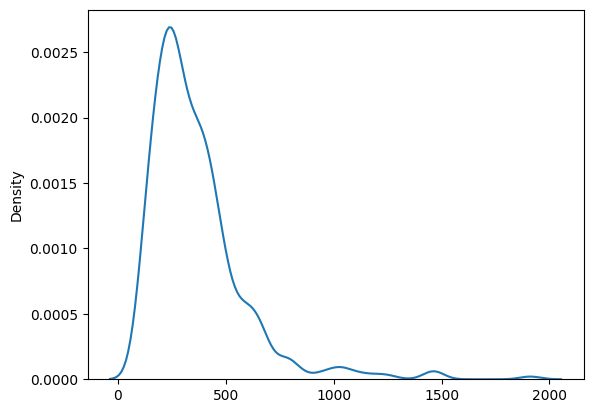

In [26]:
sns.kdeplot(pd.Series(height))

In [27]:
# image_dataset_from_directory

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    directory = paths["train"],
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(350, 350),
    shuffle=True,
    seed=42
)

test_ds = image_dataset_from_directory(
    directory = paths["test"],
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(350, 350),
    shuffle = False
)

Found 2442 files belonging to 3 classes.
Found 100 files belonging to 3 classes.


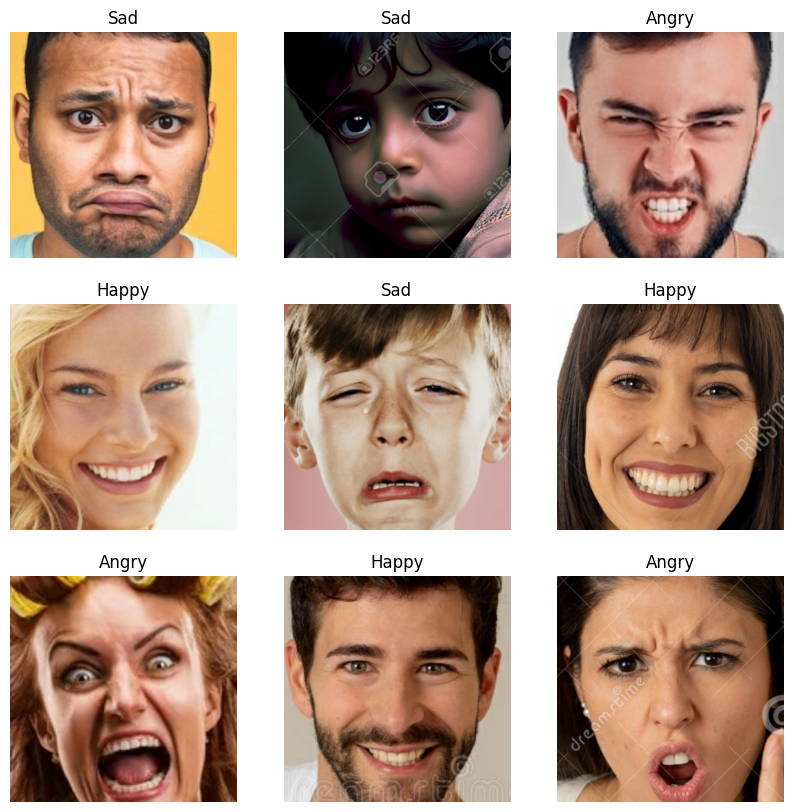

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

In [28]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    tf.random.set_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [29]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D

set_seed()

model2 = tf.keras.models.Sequential([
    InputLayer(input_shape = (350,350,3)),
    Conv2D(
        filters = 10,
        kernel_size = 5,
        strides=(1,1),
        padding='valid',
        activation = "relu"
    ),
    Conv2D(10,5,1,activation = "relu"),
    MaxPooling2D(),
    Conv2D(10,5,1,activation = "relu"),
    MaxPooling2D(),
    Conv2D(10,5,1,activation = "relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation = "relu"),
    Dense(64, activation = "relu"),
    Dense(3, activation = "softmax")
])

model2.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

result2 = model2.fit(
    train_ds, validation_data = test_ds, epochs = 5
)

Random seed set as 42
Epoch 1/5
77/77 [==============================] - 76s 906ms/step - loss: 2.9693 - accuracy: 0.6118 - val_loss: 0.6735 - val_accuracy: 0.7400
Epoch 2/5
77/77 [==============================] - 70s 908ms/step - loss: 0.2501 - accuracy: 0.9165 - val_loss: 0.5697 - val_accuracy: 0.8100
Epoch 3/5
77/77 [==============================] - 72s 930ms/step - loss: 0.0726 - accuracy: 0.9746 - val_loss: 0.6827 - val_accuracy: 0.7700
Epoch 4/5
77/77 [==============================] - 71s 914ms/step - loss: 0.0473 - accuracy: 0.9857 - val_loss: 0.6291 - val_accuracy: 0.8600
Epoch 5/5
77/77 [==============================] - 70s 900ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.7164 - val_accuracy: 0.8600


In [31]:
import tensorflow_hub as hub

efficient_net_v2 = hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-s-feature-vector/versions/2",
                                  trainable=False)


In [32]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D

set_seed()
model3 = tf.keras.models.Sequential([
    InputLayer(input_shape = (350,350,3)),
    efficient_net_v2,
    Flatten(),
    Dense(64, activation ="relu"),
    Dense(3, activation = "softmax")
])

model3.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = "accuracy"
)

result3 = model3.fit(train_ds, epochs = 5, validation_data = test_ds)


Random seed set as 42
Epoch 1/5
77/77 [==============================] - 314s 4s/step - loss: 9.1812 - accuracy: 0.4001 - val_loss: 3.3304 - val_accuracy: 0.4800
Epoch 2/5
77/77 [==============================] - 304s 4s/step - loss: 1.3388 - accuracy: 0.4959 - val_loss: 1.3823 - val_accuracy: 0.4900
Epoch 3/5
77/77 [==============================] - 300s 4s/step - loss: 0.9306 - accuracy: 0.5192 - val_loss: 1.4749 - val_accuracy: 0.4600
Epoch 4/5
77/77 [==============================] - 297s 4s/step - loss: 0.8518 - accuracy: 0.5483 - val_loss: 1.4329 - val_accuracy: 0.4500
Epoch 5/5
77/77 [==============================] - 298s 4s/step - loss: 0.7963 - accuracy: 0.5659 - val_loss: 1.6379 - val_accuracy: 0.4400


In [ ]:
# funtional Api

In [35]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D


il = tf.keras.Input(shape = (350,350,3))
c1 = Conv2D(filters = 8,kernel_size = 3, activation = "relu")(il)
mp1 = MaxPooling2D()(c1)

c2 = Conv2D(filters = 10,kernel_size = 3, activation = "relu")(mp1)
mp2 = MaxPooling2D()(c2)

flat = Flatten()(mp2)

d1 = Dense(16, activation = "relu")(flat)
ol = Dense(3, activation = "softmax")(d1)

model = tf.keras.Model(inputs = il, outputs = ol)

model.summary()




Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 350, 350, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 348, 348, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 174, 174, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 172, 172, 10)      730       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 86, 86, 10)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 73960)             0     

In [39]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPooling2D

il = tf.keras.Input(shape = (224,224,3))

c1 = Conv2D(filters = 64, kernel_size = 3, activation = "relu")(il)
c2 = Conv2D(filters = 64, kernel_size = 3, activation = "relu")(c1)
c3 = Conv2D(filters = 64, kernel_size = 3, activation = "relu")(c2)
mp1 = MaxPool2D()(c3)
c4 = Conv2D(filters = 32, kernel_size = 3, activation = "relu")(mp1)
c5 = Conv2D(filters = 32, kernel_size = 3, activation = "relu")(c4)
c6 = Conv2D(filters = 32, kernel_size = 3, activation = "relu")(c5)
mp2 = MaxPool2D()(c5)
flat = Flatten()(mp2)
d1 = Dense(16, activation = "relu")(flat)
ol = Dense(10, activation = "softmax")(d1)

model = tf.keras.Model(inputs = il, outputs = ol)
model.summary()


NameError: name 'MaxPool2D' is not defined

In [37]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.fit(train_ds,validation_data=test_ds,epoch=5)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\user\AppData\Local\Temp\ipykernel_14416\3640321576.py", line 6, in <module>
    model.fit(train_ds,validation_data=test_ds,epoch=5)
  File "C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.fit() got an unexpected keyword argument 'epoch'

During handling of the above exception, another exception occurred:

Traceback (most recent call la

In [ ]:
tf.keras.utils.plot_model(model,"my_first_model.png")

In [ ]:
# transfer learning using functional api

In [51]:
eb0=tf.keras.applications.EfficientNetB0(include_top=False,input_shape=(350,350,3))

In [52]:
eb0.layers

In [53]:
for layer_no, layer in enumerate(eb0.layers):
  print(f"{layer_no} -- {layer.trainable} --{layer}")

0 -- True --<keras.src.engine.input_layer.InputLayer object at 0x000001A6882992D0>
1 -- True --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A6882FD090>
2 -- True --<keras.src.layers.preprocessing.normalization.Normalization object at 0x000001A68833A2D0>
3 -- True --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A68836F3D0>
4 -- True --<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001A688373890>
5 -- True --<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001A68836AA50>
6 -- True --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A688346010>
7 -- True --<keras.src.layers.core.activation.Activation object at 0x000001A6882DDF10>
8 -- True --<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000001A68838A690>
9 -- True --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A688195F10>


In [54]:
eb0.layers[218].trainable

True

In [55]:
for layer_no, layer in enumerate(eb0.layers):
  if layer_no < 218:
    layer.trainable = False
  print(f"{layer_no} -- {layer.trainable} --{layer}")

0 -- False --<keras.src.engine.input_layer.InputLayer object at 0x000001A6882992D0>
1 -- False --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A6882FD090>
2 -- False --<keras.src.layers.preprocessing.normalization.Normalization object at 0x000001A68833A2D0>
3 -- False --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A68836F3D0>
4 -- False --<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001A688373890>
5 -- False --<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001A68836AA50>
6 -- False --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A688346010>
7 -- False --<keras.src.layers.core.activation.Activation object at 0x000001A6882DDF10>
8 -- False --<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000001A68838A690>
9 -- False --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A6

In [57]:
eb0.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 350, 350, 3)]        0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 350, 350, 3)          0         ['input_11[0][0]']            
                                                                                                  
 normalization_2 (Normaliza  (None, 350, 350, 3)          7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 350, 350, 3)          0         ['normalization_2

In [58]:
for layer_no, layer in enumerate(eb0.layers):
  print(f"{layer_no} -- {layer.trainable} --{layer}")

0 -- False --<keras.src.engine.input_layer.InputLayer object at 0x000001A6882992D0>
1 -- False --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A6882FD090>
2 -- False --<keras.src.layers.preprocessing.normalization.Normalization object at 0x000001A68833A2D0>
3 -- False --<keras.src.layers.preprocessing.image_preprocessing.Rescaling object at 0x000001A68836F3D0>
4 -- False --<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x000001A688373890>
5 -- False --<keras.src.layers.convolutional.conv2d.Conv2D object at 0x000001A68836AA50>
6 -- False --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A688346010>
7 -- False --<keras.src.layers.core.activation.Activation object at 0x000001A6882DDF10>
8 -- False --<keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D object at 0x000001A68838A690>
9 -- False --<keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x000001A6

In [67]:
set_seed()
il = tf.keras.Input(shape = (350,350,3))
eb = eb0(il)
flat = Flatten()(eb)
d1 = Dense(16, activation = "relu")(flat)
ol = Dense(3, activation = "softmax")(d1)

model = tf.keras.Model(inputs = il, outputs = ol)

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

model.fit(train_ds, validation_data = test_ds, epochs = 5)

Random seed set as 42
Epoch 1/5
77/77 [==============================] - 167s 2s/step - loss: 0.5694 - accuracy: 0.8186 - val_loss: 1.9092 - val_accuracy: 0.7600
Epoch 2/5
77/77 [==============================] - 158s 2s/step - loss: 0.0941 - accuracy: 0.9672 - val_loss: 0.8581 - val_accuracy: 0.8200
Epoch 3/5
77/77 [==============================] - 159s 2s/step - loss: 0.0671 - accuracy: 0.9795 - val_loss: 1.1210 - val_accuracy: 0.8000
Epoch 4/5
77/77 [==============================] - 159s 2s/step - loss: 0.0477 - accuracy: 0.9869 - val_loss: 1.0837 - val_accuracy: 0.8100
Epoch 5/5
77/77 [==============================] - 159s 2s/step - loss: 0.0843 - accuracy: 0.9803 - val_loss: 1.3046 - val_accuracy: 0.8600


In [69]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 350, 350, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 11, 11, 1280)      4049571   
 )                                                               
                                                                 
 flatten_8 (Flatten)         (None, 154880)            0         
                                                                 
 dense_18 (Dense)            (None, 16)                2478096   
                                                                 
 dense_19 (Dense)            (None, 3)                 51        
                                                                 
Total params: 6527718 (24.90 MB)
Trainable params: 3829107 (14.61 MB)
Non-trainable params: 2698611 (10.29 MB)
______________

In [70]:
set_seed()
efficientnet = tf.keras.applications.EfficientNetV2B0(include_top=False)
for layer_no, layer in enumerate(efficientnet.layers[:-18]):
  layer.trainable = False


il = tf.keras.Input(shape = (350,350,3))
en = efficientnet(il)
flat = Flatten()(en)
# drop = tf.keras.layers.Dropout(0.4)(flat)
d1 = Dense(16, activation = "relu")(flat)
drop = tf.keras.layers.Dropout(0.2)(d1)
d2 = Dense(8, activation = "relu")(drop)
drop = tf.keras.layers.Dropout(0.2)(d2)
ol = Dense(3, activation = "softmax")(drop)

model1 = tf.keras.Model(inputs = il, outputs = ol)


model1.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
    metrics = ["accuracy"]
)
model1.fit(train_ds, epochs = 10, validation_data = test_ds)

Random seed set as 42
24274472/24274472 [==============================] - 139s 6us/step
Epoch 1/10
77/77 [==============================] - 138s 2s/step - loss: 1.2709 - accuracy: 0.5287 - val_loss: 1.0564 - val_accuracy: 0.6200
Epoch 2/10
77/77 [==============================] - 119s 2s/step - loss: 0.7895 - accuracy: 0.7334 - val_loss: 0.6318 - val_accuracy: 0.7800
Epoch 3/10
77/77 [==============================] - 119s 2s/step - loss: 0.5726 - accuracy: 0.7854 - val_loss: 0.5869 - val_accuracy: 0.8700
Epoch 4/10
77/77 [==============================] - 121s 2s/step - loss: 0.4008 - accuracy: 0.8456 - val_loss: 0.6272 - val_accuracy: 0.8600
Epoch 5/10
77/77 [==============================] - 125s 2s/step - loss: 0.3195 - accuracy: 0.8898 - val_loss: 0.7177 - val_accuracy: 0.9000
Epoch 6/10
77/77 [==============================] - 121s 2s/step - loss: 0.2554 - accuracy: 0.9136 - val_loss: 0.7445 - val_accuracy: 0.8700
Epoch 7/10
77/77 [==============================] - 121s 2s/step 

In [71]:
model1.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 350, 350, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 flatten_9 (Flatten)         (None, 154880)            0         
                                                                 
 dense_20 (Dense)            (None, 16)                2478096   
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_21 (Dense)            (None, 8)                 136       
                                                           